# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)


In [ ]:
# Створимо нейронну мережу
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)
class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.relu)
        self.layer2 = tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.relu)
        self.out_layer = tf.keras.layers.Dense(num_classes)

    def __call__(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out_layer(x)
        return x


In [ ]:
def cross_entropy(y_true, y_pred):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    y_pred = tf.nn.softmax(y_pred)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_pred, y_true):
    y_true = tf.cast(y_true, tf.int64)
    predicted_class = tf.argmax(y_pred, 1)
    correct_predictions = tf.equal(predicted_class, y_true)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [ ]:
def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.Adam(learning_rate)

    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(output_y, pred)

        trainable_variables = neural_net.trainable_variables
        gradients = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Количество образцов в каждом классе:", class_counts)

Количество образцов в каждом классе: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [ ]:
#Запустить дв
neural_net = NN(name="mnist")
loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі


for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    batch_y = tf.cast(batch_y, tf.int64)
    train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(batch_y, pred)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Шаг {step}, Потери: {loss}, Точность: {acc}")



Шаг 100, Потери: 1.600096344947815, Точность: 0.8671875
Шаг 200, Потери: 1.5606169700622559, Точность: 0.890625
Шаг 300, Потери: 1.5769097805023193, Точность: 0.87890625
Шаг 400, Потери: 1.5589048862457275, Точность: 0.89453125
Шаг 500, Потери: 1.5652967691421509, Точность: 0.8828125
Шаг 600, Потери: 1.60428786277771, Точность: 0.84375
Шаг 700, Потери: 1.6076912879943848, Точность: 0.828125
Шаг 800, Потери: 1.575474739074707, Точность: 0.890625
Шаг 900, Потери: 1.587913990020752, Точность: 0.86328125
Шаг 1000, Потери: 1.5411667823791504, Точность: 0.92578125
Шаг 1100, Потери: 1.5614290237426758, Точность: 0.91015625
Шаг 1200, Потери: 1.5674505233764648, Точность: 0.88671875
Шаг 1300, Потери: 1.5859544277191162, Точность: 0.875
Шаг 1400, Потери: 1.5138136148452759, Точность: 0.94921875
Шаг 1500, Потери: 1.507920742034912, Точность: 0.97265625
Шаг 1600, Потери: 1.5020285844802856, Точность: 0.96484375
Шаг 1700, Потери: 1.4899709224700928, Точность: 0.97265625
Шаг 1800, Потери: 1.49391198

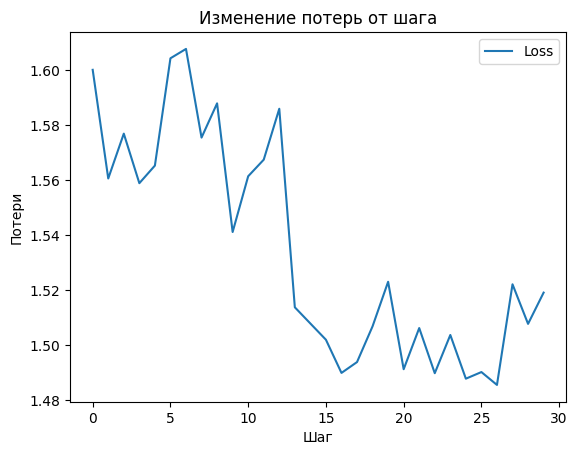

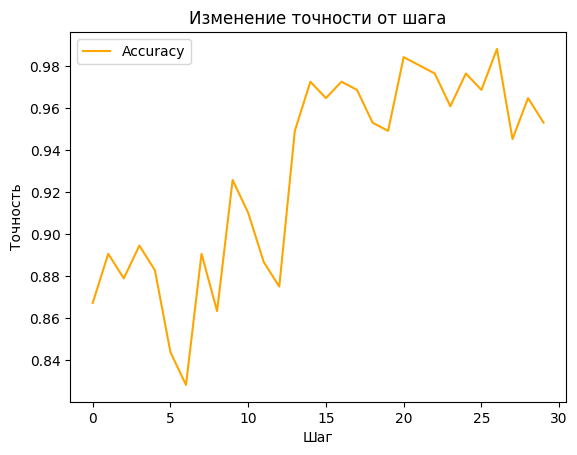

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_history, label='Loss')
plt.title('Изменение потерь от шага')
plt.xlabel('Шаг')
plt.ylabel('Потери')
plt.legend()
plt.show()

plt.plot(accuracy_history, label='Accuracy', color='orange')
plt.title('Изменение точности от шага')
plt.xlabel('Шаг')
plt.ylabel('Точность')
plt.legend()
plt.show()


In [ ]:
x_test = tf.cast(x_test, dtype=tf.float32)

test_accuracy = accuracy(neural_net(x_test), y_test)

print(f'Точность модели: {test_accuracy:.4f}')
predictions = neural_net(x_test)

test_accuracy = accuracy(predictions, y_test)

print(f'Точность на тестовом наборе данных: {test_accuracy:.4f}')

Точность модели: 0.9547
Точность на тестовом наборе данных: 0.9547


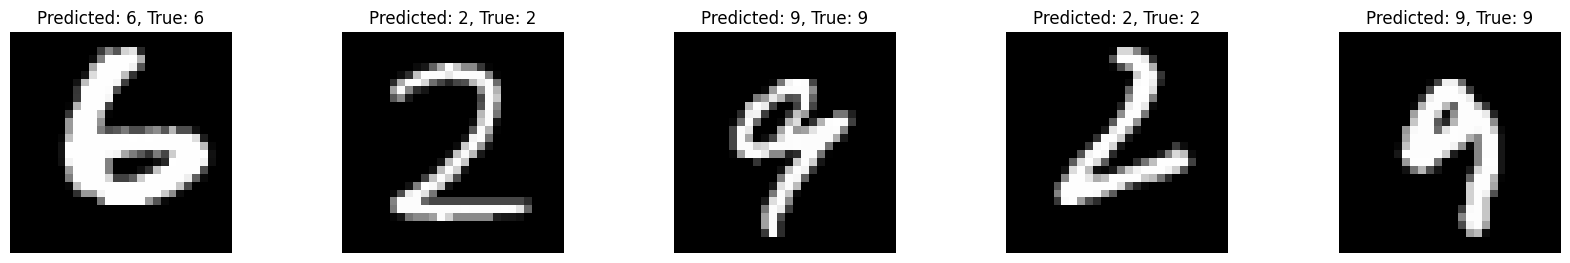

Количество угаданных: 5, количество ошибочных: 0


In [ ]:
import random
import matplotlib.pyplot as plt

num_images_to_show = 5

random_indices = random.sample(range(len(x_test)), num_images_to_show)
images_to_show = tf.gather(x_test, random_indices)
labels_to_show = tf.gather(y_test, random_indices)

predictions = neural_net(images_to_show)

plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.5)
correct_predictions = 0
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i+1)
    if tf.argmax(predictions[i], axis=0) == tf.cast(labels_to_show[i], tf.int64):
        plt.imshow(images_to_show[i].numpy().reshape(28, 28), cmap='gray')
        plt.title(f'Predicted: {tf.argmax(predictions[i], axis=0).numpy()}, True: {labels_to_show[i].numpy()}')
        correct_predictions += 1
    else:
        plt.imshow(images_to_show[i].numpy().reshape(28, 28), cmap='Reds')
        plt.title(f'Predicted: {tf.argmax(predictions[i], axis=0).numpy()}, True: {labels_to_show[i].numpy()} (Incorrect)')
    plt.axis('off')

plt.show()


print(f'Количество угаданных: {correct_predictions}, количество ошибочных: {num_images_to_show - correct_predictions}')
